## Analyze heart disease using 14 attributes

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

In [103]:
def over_view(df):
    print('null summary: ', df.isnull().sum().sum(), '\n')
    print('rows: ', len(df), '\n')
    print('columns', list(df.columns), '\n')
    print(df.head())
    print(df.info())

In [104]:
cols = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']
heart = pd.read_csv('./data/processed.cleveland.data', names = cols)
over_view(heart)

null summary:  0 

rows:  303 

columns ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'] 

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  num  
0    3.0  0.0  6.0    0  
1    2.0  3.0  3.0    2  
2    2.0  2.0  7.0    1  
3    3.0  0.0  3.0    0  
4    1.0  0.0  3.0    0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null float64
sex         303 non-null float64
cp          303 non-null float64
trestbps    303

### Convert outcome num (0 for healthy, 1-4 for disease) to Boolean Class. 

In [105]:
heart['health']=heart['num'].apply(lambda x: 0 if x == 0 else 1)
heart[['num','health']].head(10)

,num,health
0,0,0
1,2,1
2,1,1
3,0,0
4,0,0
5,0,0
6,3,1
7,0,0
8,2,1
9,1,1


### Ca and thal are labeled as 'object' in type, because there are missing values which are not marked as NaN

In [106]:
heart.groupby(['ca'])['health'].mean()

ca
0.0    0.261364
1.0    0.676923
2.0    0.815789
3.0    0.850000
?      0.250000
Name: health, dtype: float64

In [107]:
heart.groupby(['thal'])['health'].mean()

thal
3.0    0.222892
6.0    0.666667
7.0    0.760684
?      0.500000
Name: health, dtype: float64

In [108]:
heart[heart['ca']=='?'].ix[:,('ca','health')]

,ca,health
166,?,0
192,?,1
287,?,0
302,?,0


In [109]:
#replace ca(?) with 0.0 for health(0) and 1.0 (or 2.0 or 3.0) for health(1).
heart.ix[166, 'ca']=0.0
heart.ix[192, 'ca']=1.0
heart.ix[287, 'ca']=0.0
heart.ix[302, 'ca']=0.0

In [110]:
heart[heart['thal']=='?'].ix[:,('thal','health')]

,thal,health
87,?,0
266,?,1


In [111]:
#replace thal(?) with 3 for health(0) and 6 (or 7) for health(1).
heart.ix[87, 'thal']=3
heart.ix[266, 'thal']=6

In [112]:
X = heart.drop(['health','num'], axis=1)
y = heart['health']

In [113]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [114]:
params1 = {'criterion':['gini','entropy'],
           'splitter':['best','random'],
           'min_samples_split':[2,5,8,11],
           'min_samples_leaf':[10,15,20,25,30]}
kf1 = KFold(n_splits=10, shuffle=True)
gs1 = GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=params1,cv=kf1,scoring='accuracy')
tree_mod = gs1.fit(X_train, y_train)
print('Done!')

Done!


In [117]:
#output the results
#print(pd.DataFrame(tree_mod.cv_results_))
print('\n',tree_mod.best_estimator_)
print('\n','Best Score: ',tree_mod.best_score_)


 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')

 Best Score:  0.811320754717


In [123]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
%matplotlib inline
#creating a plot_roc_curve funstion that we can call later
def plot_roc_curve(target_test, target_predicted_proba, label):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:,1], drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    fig, ax = plt.subplots(figsize=(3.5,3.5))
    ax.plot(fpr, tpr, 'r-', label= label + '\n' + 'ROC Area = %0.3f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k-.')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('False Positive Rate (1 - Specifity)', fontsize=12)
    ax.set_ylabel('True Positive Rate (Sensitivity)',fontsize=12)
    plt.legend(loc='lower right',fontsize=12)
    plt.title('Receiver Operating Characteristic',fontsize=12)

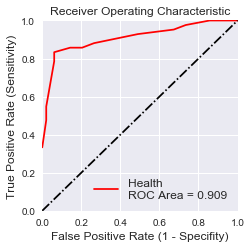

In [124]:
plot_roc_curve(y_test, tree_mod.predict_proba(X_test), 'Health')

In [131]:
#create the tree classifer using the best estimators
tree_clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_split=1e-07, min_samples_leaf=10,
                                min_samples_split=5, min_weight_fraction_leaf=0.0,
                                presort=False, random_state=None, splitter='random')
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')

In [132]:
pd.DataFrame({'feature':X.columns, 'importance':tree_clf.feature_importances_})

,feature,importance
0,age,0.026128
1,sex,0.074240
2,cp,0.438110
3,trestbps,0.004571
4,chol,0.000000
5,fbs,0.000000
6,restecg,0.021764
7,thalach,0.000000
8,exang,0.061145
9,oldpeak,0.000000


In [137]:
from sklearn.tree import export_graphviz
from os import system 

def tree_dot(model,feat_df):
    f = open("./data/tree.dot", 'w')
    export_graphviz(decision_tree=model,out_file=f,feature_names=feat_df.columns)
    f.close()

tree_dot(tree_clf, X)

In [138]:
system('dot -Tpng ./data/tree.dot -o ./data/tree.png')

0

<img src="./data/tree.png">